In [21]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torch.utils.data as data
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
# Compute means and standard deviations along the R,G,B channel
ROOT = "/CIFAR10/"
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

100%|██████████| 170498071/170498071 [00:03<00:00, 56306494.12it/s]


Extracting /CIFAR10/cifar-10-python.tar.gz to /CIFAR10/


In [3]:
print(means)
print(stds)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [4]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [5]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [8]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [9]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

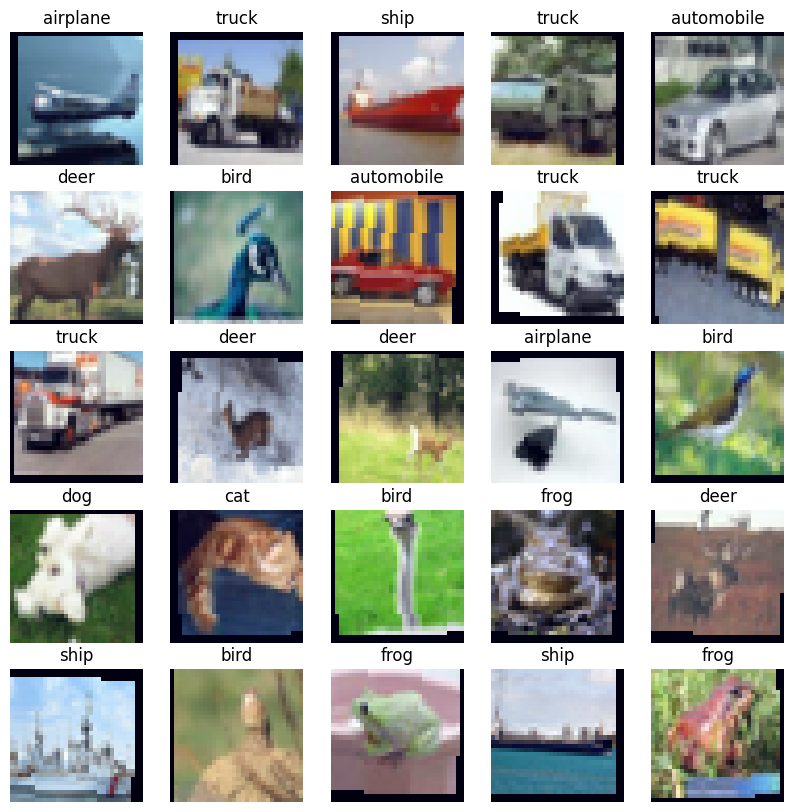

In [10]:
plot_images(images, labels, classes, normalize = True)

In [11]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [12]:
BATCH_SIZE = 256

train_iterator = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_iterator = torch.utils.data.DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)
test_iterator = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [34]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [35]:
def ResNet18():
    return ResNet(BasicBlock, [2, 1, 1, 1])

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18()
model = model.to(device)

In [37]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

4980234

In [38]:
import torchsummary
torchsummary.summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

In [39]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [40]:
model.apply(initialize_parameters)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [42]:
import torch.optim as optim
learning_rate = 0.001
curr_lr = learning_rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=100*len(train_iterator))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [43]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [44]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()

        # Update the learning rate
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [45]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [47]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [48]:
EPOCHS = 100

max_validation_accuracy = 0

for epoch in range(EPOCHS):
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  print(f'Epoch {epoch}, Train loss {train_loss}, Train accuracy {train_acc}, Validation loss {valid_loss}, Validation accuracy {valid_acc}')

  if(valid_acc >= max_validation_accuracy):
    print(f"Validation accuracy increased from {max_validation_accuracy:.2f} to {valid_acc:.2f}")
    max_validation_accuracy = valid_acc
    torch.save(model.state_dict(), 'model')

  if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch 0, Train loss 1.6533556546677242, Train accuracy 0.3938680751757188, Validation loss 1.3553033828735352, Validation accuracy 0.5028837323188782
Validation accuracy increased from 0.00 to 0.50
Epoch 1, Train loss 1.2548574534329502, Train accuracy 0.5461408025161787, Validation loss 1.1582822859287263, Validation accuracy 0.588648897409439
Validation accuracy increased from 0.50 to 0.59
Epoch 2, Train loss 1.083814244378697, Train accuracy 0.6146022724834356, Validation loss 1.081439670920372, Validation accuracy 0.6173368573188782
Validation accuracy increased from 0.59 to 0.62
Epoch 3, Train loss 0.956071903759783, Train accuracy 0.6607386361468922, Validation loss 0.9625810980796814, Validation accuracy 0.6640625
Validation accuracy increased from 0.62 to 0.66
Epoch 4, Train loss 0.8745629313317212, Train accuracy 0.6889337711036205, Validation loss 0.9164277940988541, Validation accuracy 0.6841222435235977
Validation accuracy increased from 0.66 to 0.68
Epoch 5, Train loss 0.7

In [49]:
model.load_state_dict(torch.load('model'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test loss {test_loss}, Test accuracy {test_acc}')

Test loss 0.21324948016554118, Test accuracy 0.93544921875


In [50]:
torch.save(model.state_dict(), 'resnet_model_93.54.ckpt')